#Implementing our own FALCOR
Let's start by setting up our workspace and importing useful packages. If you are missing any of the essential packages you have to install them before continuing.

In [1]:
#Set up the Kernel

#Essential packages
import scipy as sp
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import groupby as gb

mpl.rcParams['font.sans-serif']='Helvetica'
mpl.rcParams['legend.numpoints'] = 1

#Optional packages
import pickle
import beeswarm as bs
import pandas as pd

#Make all the plots in the document.
%matplotlib inline   

##Define the functions
All these formulas were gotten either from the <a href="http://www.keshavsingh.org/protocols/FALCOR.html#implementation">FALCOR</a> page or the <a href="http://www.sciencedirect.com/science/article/pii/S1046202399909015">Rosche and Foster</a> paper.

###Ma-Sandri-Sarkar function
This function calculates the probability of observing a certain number of mutants (<strong>r</strong>) given a per culutre mutation rate (<strong>m</strong>).

It is written as: 
$$p_0=e^{-m}$$

$$p_r=\frac{m}{r}\sum^{r-1}_{i=0}\frac{p_i}{(r-i-1)}$$

Where <strong>m</strong> is the mutation rate and <strong>r</strong> is the number of colonies per plate.

In [2]:
#Define the function to calculate the probability of observing r mutants given a mutation rate

def MSS(r, m, return_all=True):
    """Calculate the probability for observing
    r mutants given a mutation rate m.
    
    INPUT:
    -----
    r: number of mutants (int)
    m: mutation rate (per genome)
    
    OUTPUT:
    ------
    Pr(r|m): float
    
    NOTES:
    -----
    Based on: http://www.keshavsingh.org/protocols/FALCOR.html#implementation
    """
    
    def p0(m):
        return np.exp(-m)
    
    _i = 0
    _pr = [p0(m)]
    _denom = [r-_i+1.]
    
    if r>0:
        #First term
        _denom = [1.]
        for i in range(0,r):
            _denom = range(2,i+3)[::-1]
            _pr.append((float(m)/(i+1))*sum([x/_denom[f] for f,x in enumerate(_pr)]))
    
    if return_all!=True: _pr = _pr[-1]
    
    return _pr

###Maximum likelihood approach to estimating m.
The output of the MSS is a probability, therefore the product of all the probabilities for a given experiment at a given <strong>m</strong> gives the composite probabilty of observing our results at that <strong>m</strong>.

The maximum likelihood estimation looks for the <strong>m</strong> that best fits our observations. We therefore need to run an optimization routine on the following function:

$$f(r|m)=\prod_{i=0}^{r}(p_{r_i}^{C_i})$$

Where <strong>$p_{r_i}^{C_i}$</strong> is the probability of observing <strong>r</strong> mutants raised to the power of the number of plates with that result - <strong>C</strong>. This comes out of the multiplication rule of probability. So it is really the multiplication of all the probabilities involved in the experiment.

The optimization routine looks for the <strong>m</strong> that gives the highest possible value for $f(r|m)$. That is then the maximum likelihood estimate for <strong>m</strong>.

Note that in order to limit the execution time of the functions in Python I have limited the maximum value that <strong>r</strong> can take to 150. I have done this according to the points discussed by Rosche and Foster. In cases where the <strong>m</strong> is estimated to be over 15 then this apporximation will have to be revisited.

In [3]:
#Define the function to calculate the probability of observing the measured distribution 
#of mutants given a mutation rate
    
def MSS_MLE_function(data,m):
    """Calcualte the pr from equation 17
    in Rosche and Forster, Methods, 2000
    
    INPUT:
    -----
    data: list of results
    m: number of mutants per culture
    
    OUTPUT:
    ------
    pr: the probability of the of observing
    the data at a given mutation rate.
    
    NOTES:
    -----
    This function can be used for the optimisation
    routine.
    """
    _r = np.array([_items for _items,_counts in gb(sorted(data))])
    _c = np.array([len(list(_counts)) for _items,_counts in gb(sorted(data))])
    
    _N_max = np.max(_r)
    
    #Jackpot events will increase the calculation time on an exponential
    #scale. One way to deal with them is to bin everything that falls
    #above 150 into the same bin. Rosche and Forster say that below M=15
    #this should not significantly impact the result.
    
    if _N_max>150:
        _N_max=150
        _r[_r>150]=150
    
    return np.product(np.array(MSS(_N_max,m))[_r]**np.array(_c))

#Implement the Scipy optimization routine     

def MSS_MLE(data, bounds=(0,20)):
    """Maximum likelihood estimation of mutation
    rates based on the MSS-MLE method.
    
    INPUT:
    -----
    data: list/nd.array of counts per culture
    bounds: tuple, lower and upper bounds for the optimisation
     
    OUTPUT:
    ------
    estimated M
     
    NOTES:
    -----
    m = M/Nt, function based on Rosche and Forster 2000.
    """
    
    objFunc = lambda m: -MSS_MLE_function(data,m) #objective function to feed into the optimizer
                                                  #note the the MSS_MLE_funciton has a - before it
                                                  #meaning it maximises the function not minimises.
                                                  
    par_mle = sp.optimize.fminbound(objFunc, bounds[0], bounds[1]) #optimizing routine
    return par_mle

###Calculating the confidence intervals for the estimate of m.

In [4]:
#Calculate confidence intervals for an estimate
    
def MSS_MLE_CI(m, C):
    """Calculate the confidence intervals for a mutation
    rate estimation.
    
    INPUT:
    -----
    m: float, number of mutants as estimated from MSS_MLE
    C: int, number of cultures
    
    OUTPUT:
    ------
    tup (+CI, -CI)
    
    NOTES:
    -----
    Based on Rosche and Forster, Mehods, 2000.
    """
    
    _sigma = (1.225*m**-0.315)/np.sqrt(C)
    
    _CI_U = np.exp(np.log(m)+1.96*_sigma*(np.exp(1.96*_sigma))**-0.315)
    _CI_L = np.exp(np.log(m)-1.96*_sigma*(np.exp(1.96*_sigma))**0.315)
    
    return (_CI_L, _CI_U)

###Correction for plating only part of the whole culture.

In [5]:
#Code the fractional plating correction function
def plating_correction(m, fraction):
    """Correct for incomplete plating
    
    INPUT:
    -----
    m: float, number of mutants as estimated from MSS_MLE
    fraction: float, fraction of culture plated (0-1)
    
    OUTPUT:
    ------
    adjusted_m: float
    
    NOTES:
    -----
    Based on http://www.keshavsingh.org/protocols/FALCOR.html#implementation
    """
    
    return m*((fraction-1)/fraction*np.log(fraction))

###T-test for pairwise comparison of mutation rates.

In [6]:
#Code the t-test for the pairwise comparison of mutation rates.
def m_Ttest(m1, m2, C1, C2):
    """Perform a t-test comparing two mutation rates
    
    INPUTS:
    ------
    m1, m2: mutation rates from MSS_MLE to be compared
    C1, C2: number of cultures used for each experiment
    
    OUTPUT:
    ------
    tup: (T,p)
    
    NOTES:
    -----
    Based on eq.5 in http://www.keshavsingh.org/protocols/FALCOR.html#implementation
    """
    
    _sigma1 = (1.225*m1**-0.315)/np.sqrt(C1)
    _sigma2 = (1.225*m1**-0.315)/np.sqrt(C2)
    
    _df = C1+C2-2
    
    t = (np.log(m1)-np.log(m2))/np.sqrt(_sigma1**2/C1+_sigma2**2/C2)
    
    print (t,2*ss.t.sf(np.abs(t),_df))

##Datasets

In [7]:
#Start from defining the data here, will add an importer later

#Rosche & Foster data

#Data in Table 3
data_RF = [0,]*11+[1,]*19+[2,]*12+[3,]*5+[4,]*4+[5,6,7,7,9,12,21,32,3000]
Nt_RF = 1.5e8

#Rhastin's data from Feb 2015 (Msm grown in 24-well plates, plated onto 7H10 with 100ug/ml RIF)

#Colony counts per culture/plate
s001 = [5,0,9,2,1,1,0,0,2,5,0,0]
s002 = [7,9,3,5,4,2,2,5,1,5,3,4]
s003 = [2,1120,4,3,7,33,1,0,1,2,0,2]
s004 = [11,2,0,0,1,3,2,4,1,4,0,3]

s001_2 = [19,18,5,1,3,12,7,4,251,6,8,4,0,1,0,1,0,0,4,4,38,1,4,4]
s003_2 = [156,32,396,39,35,0,520,532,292,724,648,768,130,113,35,500,232,596,22,13,109,78,156,67]

#Nt determinations (assuming 15ul spots and 5ml of totla cultures plated)

Nt1 = (((13+20+2+12+24+8)/6.)/15.)*10000*1000*5
Nt2 = (((55+71+60+16+48+57)/6.)/15.)*10000*1000*5
Nt3 = ((5/6.)/15.)*10000*1000*5
Nt4 = (((38+20+20+27+19+22)/6.)/15.)*100000*1000*5

Nt1_2 = (((13+7+15+20+16+13)/6.)/15.)*100000*1000*4.3
Nt3_2 = (((51+59+68+50+47+46)/6.)/15.)*10000*1000*4.3


##Check functions

Use the <a href"http://www.sciencedirect.com/science/article/pii/S1046202399909015">Rosche & Foster</a> paper to confirm that the functions are well behaved and that our apporach is valid.

To do that we will use the above data the results for which are processed and presented as "Experiment 2" in Table 4 of the paper. Note that they report the mutation per culture.

><strong>m</strong> = 1.23, CI95(0.90-1.60)

In [8]:
#Estimate the mutation rate from their data
m_RF = MSS_MLE(data_RF, bounds=(0,20)) 

#The bounds for the optimisation are given as 0,20.
#If the calculated m equals the upper bound, then
#the bounds need to be adjusted.

prs= [MSS_MLE_function(data_RF, x) for x in np.arange(0.01,2,.01)]

CI = MSS_MLE_CI(m_RF, len(data_RF))

print 'Our calculated mutation rate is: %.2f (CI95: %.2f - %.2f).' %(m_RF, CI[0], CI[1]) 

Our calculated mutation rate is: 1.23 (CI95: 0.89 - 1.60).


Yay - looks like the functions are correctly coded. 

The cool thing is that we can now actually have a look at how all our estimates actually fit the data:

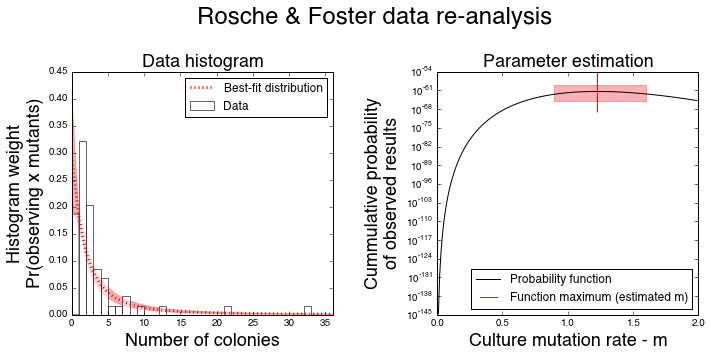

In [9]:
plt.figure('RF_data', figsize=(10,5))
plt.subplot(121)
plt.title('Data histogram', size=18)
plt.hist(data_RF, bins=np.arange(0,150,1),normed=True,color='white',label='Data',alpha=0.6)
plt.plot(np.arange(0,150,1), MSS(149,m_RF), 'r:',label='Best-fit distribution', lw=3)
plt.fill_between(np.arange(0,150,1), MSS(149,CI[0]), MSS(149,CI[1]), color='red', alpha=0.3)
plt.xlabel('Number of colonies', size=18)
plt.ylabel('Histogram weight\nPr(observing x mutants)', size=18)
plt.xlim(0,36)
plt.legend()
plt.subplot(122)
plt.title('Parameter estimation', size=18)
plt.plot(np.arange(0.01,2,.01),prs,'k-',label='Probability function')
plt.vlines(m_RF, 10e-70, 10e-55,color='red',label='Function maximum (estimated m)')
plt.fill_between(np.arange(CI[0], CI[1]+.01, .01),10e-66, 10e-60, color='red', alpha=0.3)
plt.yscale('log')
plt.xlabel('Culture mutation rate - m', size=18)
plt.ylabel('Cummulative probability\nof observed results', size=18)
plt.suptitle('Rosche & Foster data re-analysis', size=24)
plt.legend(loc=4)
plt.subplots_adjust(top=0.80,left=0.08,right=.95,wspace=0.40)
plt.savefig('150612_MSS_MLE_17_0.pdf')

In [15]:
data_RAC = np.array([s001, s002,s003,s004])
Nt = np.array([Nt1, Nt2, Nt3, Nt4])
ms = np.array([MSS_MLE(x) for x in data_RAC])
CI_ms = [MSS_MLE_CI(val, len(data_RAC[ind])) for ind,val in enumerate(ms)]

In [11]:
data_RAC = np.array([s001_2,s003_2])
Nt = np.array([Nt1_2, Nt3_2])
ms = np.array([MSS_MLE(x) for x in data_RAC])
CI_ms = [MSS_MLE_CI(val, len(data_RAC[ind])) for ind,val in enumerate(ms)]

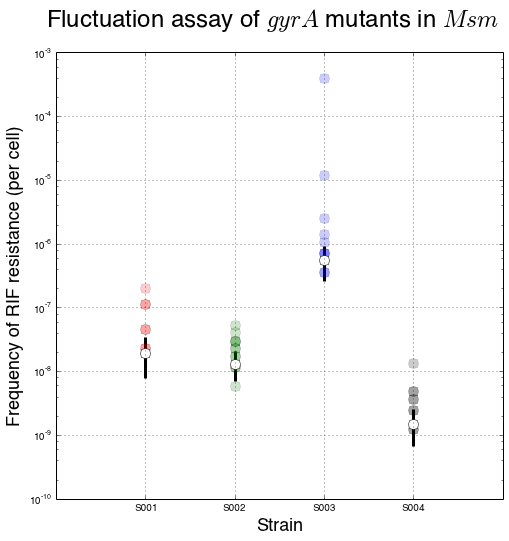

In [16]:
cols = 'rgbk'
plt.figure('Rhastin_FA', figsize=(8,8))
for ind,val in enumerate(np.arange(4)):
    plt.plot([val,]*len(data_RAC[ind]), data_RAC[ind]/Nt[ind],'%so' %cols[ind],ms=10,alpha=0.2)
    plt.vlines(val, CI_ms[ind][0]/Nt[ind], CI_ms[ind][1]/Nt[ind], colors='k',lw=3)
plt.plot(ms/Nt, 'ko', mfc='white', ms=10)
plt.yscale('log')
plt.xlim(-1,4)
plt.xticks(np.arange(0,4), ['S001', 'S002','S003','S004'])
plt.xlabel('Strain', size=18)
plt.ylabel('Frequency of RIF resistance (per cell)', size=18)
plt.suptitle(r"Fluctuation assay of $gyrA$ mutants in $Msm$", size=24)
plt.grid()
plt.savefig('150612_MSS_MLE_19_0.pdf')

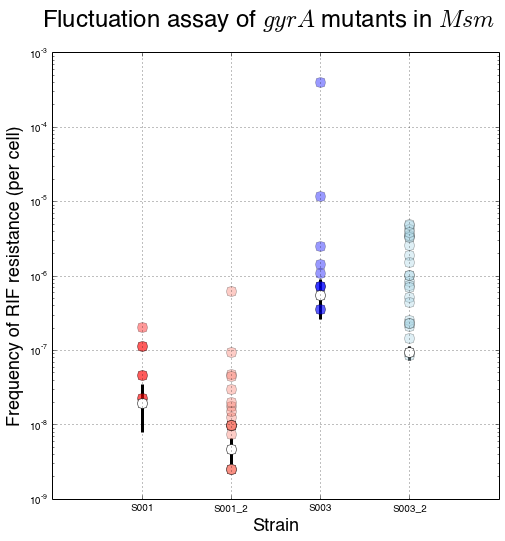

In [21]:
data_RAC = np.array([s001, s001_2,s003,s003_2])
Nt = np.array([Nt1, Nt1_2, Nt3, Nt3_2])
ms = np.array([MSS_MLE(x) for x in data_RAC])
CI_ms = [MSS_MLE_CI(val, len(data_RAC[ind])) for ind,val in enumerate(ms)]

cols = ['red','salmon','blue','lightblue']
plt.figure('Rhastin_FA', figsize=(8,8))
for ind,val in enumerate(np.arange(4)):
    plt.plot([val,]*len(data_RAC[ind]), data_RAC[ind]/Nt[ind],'o', color=cols[ind],ms=10,alpha=0.4)
    plt.vlines(val, CI_ms[ind][0]/Nt[ind], CI_ms[ind][1]/Nt[ind], colors='k',lw=3)
plt.plot(ms/Nt, 'ko', mfc='white', ms=10)
plt.yscale('log')
plt.xlim(-1,4)
plt.xticks(np.arange(0,4), ['S001', 'S001_2','S003','S003_2'])
plt.xlabel('Strain', size=18)
plt.ylabel('Frequency of RIF resistance (per cell)', size=18)
plt.suptitle(r"Fluctuation assay of $gyrA$ mutants in $Msm$", size=24)
plt.grid()
plt.savefig('150706_MSS_MLE_S001_3_comp.pdf')

In [26]:
print 'Feb S001 mutants per cell: %.2e (CI95: %.2e - %.2e).' %(ms[0]/Nt1, CI_ms[0][0]/Nt1, CI_ms[0][1]/Nt1) 
print 'Jun S001 mutants per cell: %.2e (CI95: %.2e - %.2e).' %(ms[1]/Nt1_2, CI_ms[1][0]/Nt1_2, CI_ms[1][1]/Nt1_2) 
print 'Feb S003 mutants per cell: %.2e (CI95: %.2e - %.2e).' %(ms[2]/Nt3, CI_ms[2][0]/Nt3, CI_ms[2][1]/Nt3) 
print 'Jul S003 mutants per cell: %.2e (CI95: %.2e - %.2e).' %(ms[3]/Nt3_2, CI_ms[3][0]/Nt3_2, CI_ms[3][1]/Nt3_2) 

Feb S001 mutants per cell: 1.97e-08 (CI95: 7.90e-09 - 3.51e-08).
Jun S001 mutants per cell: 4.68e-09 (CI95: 2.96e-09 - 6.66e-09).
Feb S003 mutants per cell: 5.50e-07 (CI95: 2.64e-07 - 9.07e-07).
Jul S003 mutants per cell: 9.26e-08 (CI95: 7.38e-08 - 1.13e-07).


In [28]:
print m_Ttest(ms[0],ms[2],len(s001),len(s003))
print m_Ttest(ms[1],ms[3],len(s001_2),len(s003_2))

(-3.7723212804149542, 0.0010492189330328194)
None
(-34.179639985589894, 2.4021126994222725e-34)
None


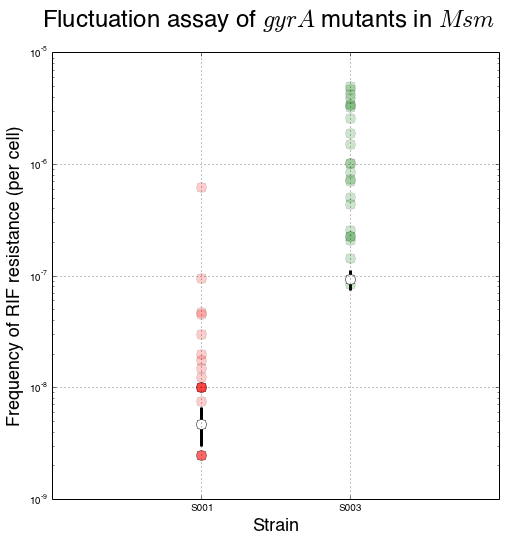

In [14]:
cols = 'rgbk'
plt.figure('Rhastin_FA', figsize=(8,8))
for ind,val in enumerate(np.arange(2)):
    plt.plot([val,]*len(data_RAC[ind]), data_RAC[ind]/Nt[ind],'%so' %cols[ind],ms=10,alpha=0.2)
    plt.vlines(val, CI_ms[ind][0]/Nt[ind], CI_ms[ind][1]/Nt[ind], colors='k',lw=3)
plt.plot(ms/Nt, 'ko', mfc='white', ms=10)
plt.yscale('log')
plt.xlim(-1,2)
plt.xticks(np.arange(0,2), ['S001', 'S003'])
plt.xlabel('Strain', size=18)
plt.ylabel('Frequency of RIF resistance (per cell)', size=18)
plt.suptitle(r"Fluctuation assay of $gyrA$ mutants in $Msm$", size=24)
plt.grid()
plt.savefig('150706_MSS_MLE_19_0.pdf')

In [12]:
prs1= [MSS_MLE_function(s001, x) for x in np.arange(0.01,4,.01)]
prs2= [MSS_MLE_function(s002, x) for x in np.arange(0.01,4,.01)]
prs3= [MSS_MLE_function(s003, x) for x in np.arange(0.01,4,.01)]
prs4= [MSS_MLE_function(s004, x) for x in np.arange(0.01,4,.01)]

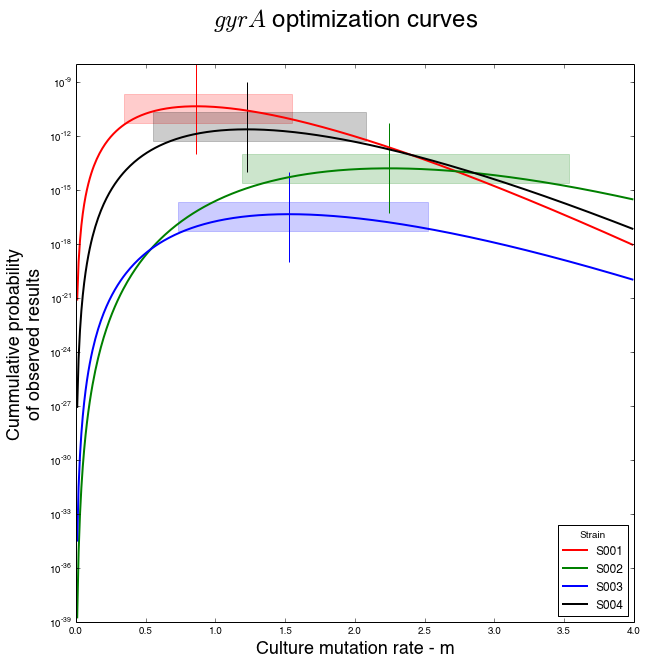

In [13]:
prs_RAC = [prs1, prs2, prs3, prs4]
lims_RAC = [(10e-9, 10e-14),(5e-12, 5e-17),(10e-15, 10e-20),(10e-10, 10e-15)]

plt.figure('rhastin_prs', figsize=(10,10))
cols = 'rgbk'
for ind, val in enumerate(prs_RAC):
    plt.plot(np.arange(0.01,4,.01),val, color=cols[ind],lw=2,label='Probability function')
    plt.vlines(ms[ind], lims_RAC[ind][0], lims_RAC[ind][1],color=cols[ind],label='Function maximum (estimated m)')
    plt.fill_between(np.arange(CI_ms[ind][0], CI_ms[ind][1]+.01, .01), lims_RAC[ind][0]/50, lims_RAC[ind][1]*50, color=cols[ind], alpha=0.2)
    plt.yscale('log')
    plt.xlabel('Culture mutation rate - m', size=18)
    plt.ylabel('Cummulative probability\nof observed results', size=18)
plt.suptitle(r'$gyrA$ optimization curves', size=24)
plt.legend(['S001', 'S002', 'S003', 'S004'],loc=4,title='Strain')
plt.savefig('150612_MSS_MLE_21_1.pdf')